## Importar Librerias

In [1]:
# Importar algunos módulos nativos de Python
import datetime

# Importar las librerías necesarias
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb

# Puede que nos sirvan también
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_curve
)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from yellowbrick.regressor import ResidualsPlot

from utils import display_markdown

np.random.seed(0)  # Para mayor determinismo

/home/javiergallo/miniconda3/envs/diplodatos/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1.Carga de datos

Al final del practico anterior obtuvimos un dataset enriquesido con features georeferenciadas. Es el momento de utilizarlo.

Exporta el dataframe obtenido en el ultimo practico a un csv y cargalo como dataframe.

In [2]:
dataframe = pd.read_csv(
    './data/curated_data.csv',
    sep='\t',
    parse_dates=['DAT_CON', 'TR_S_DAT_CON'],
    date_parser=lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
)
dataframe

/home/javiergallo/miniconda3/envs/diplodatos/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


,COD_ID,CONJ,MUN,ARE_LOC,geometry,UNI_TR_S,DIC,FIC,CNAE,ENE_01,...,n_close_con,is_urb,NODE,ENDNODE,g_degree,g_avg_ndeg,g_pagerank,g_dispersion,eigenvector_centrality,dist_to_trs_dijkstra
0,4_1040341,12737,2805802,NU,POINT (627712.6169779997 8776098.670127511),1_SESAQ_1,7.050,8.0,0,147,...,1,False,45297,44304,2,2.0,0.000012,"{'45298': 0.0, '45296': 0.0}",5.680527e-06,110
1,4_1040306,12737,2805802,NU,POINT (626353.4179798126 8777498.606078334),1_SESAQ_1,5.470,7.0,0,275,...,1,False,45268,44304,1,2.0,0.000007,{'45269': 0.0},2.625699e-06,126
2,4_1040035,12737,2805802,NU,POINT (635724.1370160332 8773322.662057359),1_SESAQ_1,7.130,7.0,0,1732,...,14,False,46283,44304,2,2.0,0.000012,"{'46285': 0.0, '46282': 0.0}",4.072908e-07,240
3,4_1040036,12737,2805802,NU,POINT (638696.4859638879 8773991.73208276),1_SESAQ_1,5.190,6.0,0,692,...,9,False,46525,44304,1,3.0,0.000006,{'46408': 0.0},7.984421e-07,233
4,4_1040038,12737,2805802,NU,POINT (638310.7990282972 8773035.106081862),1_SESAQ_1,5.840,7.0,0,1297,...,10,False,46406,44304,2,2.0,0.000012,"{'46438': 0.0, '46517': 0.0}",3.746185e-07,261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,8_1080578,12730,2802809,NU,POINT (653013.3989592987 8739601.889035663),1_SECON_1,21.510,10.0,0,1206,...,12,False,65017,68429,2,2.0,0.000012,"{'65016': 0.0, '65018': 0.0}",4.457296e-07,321
8829,8_1080577,12730,2802809,NU,POINT (653309.3439843655 8739968.353031982),1_SECON_1,21.510,10.0,0,1469,...,8,False,64978,68429,2,2.0,0.000012,"{'65005': 0.0, '65004': 0.0}",2.614774e-07,334
8830,12_1120421,12730,2807600,NU,POINT (644710.9110109408 8734252.079058295),1_SECON_1,21.130,9.0,0,189,...,1,False,65134,68429,1,2.0,0.000007,{'65245': 0.0},1.424013e-07,434
8831,8_1080557,12730,2802809,NU,POINT (673768.0680233241 8730109.019107511),1_SECON_1,11.435,6.0,0,69,...,4,False,680043,71128,1,2.0,0.000007,{'680042': 0.0},1.931153e-07,139


Ahora debemos eliminar variables que no aporte informacion por ejemplo:


*   Indices y IDs
*   Referencias a otras tablas
*   Variables compuestas (listas, jsons, geometrias)

Identifica las variables que cumplen este criterio y eliminelas del dataset. Retira tambien la variable de salida que no van a utilizar FIC o DIC.



In [3]:
# Eliminar índices, IDs y variables compuestas.
dataframe.drop(
    columns=[
        'COD_ID', 'PAC_1', 'PAC_2', 'geometry', 'TR_S_geometry',
        'g_dispersion', 'TR_S_COD_ID', 'UNI_TR_S', 'TR_S_BARR_1',
        'TR_S_BARR_2'
    ],
    inplace=True,
    errors='ignore'
)

# Eliminar las siguientes variables dado que:
# TR_S_BARR_3 == '' para todas las filas,
# DIST == 46 para todas las filas,
# CONF == 'RA' para todas las filas excepto una,
# POSTO == 'PT' para todas las filas,
# BANC == 0 para todas la filas,
# MRT == 0 para todas la filas,
# DESCR = '' para todas las filas,
# SIT_ATIV = 'AT' para todas las filas excepto una,
# TIP_UNID = 38 para todas las filas,
# ATRB_PER = 1 para casi todas las filas,
# CAP_CHA = 1 para casi todas las filas,
# POS = 'PD' para casi todas las filas.
dataframe.drop(
    columns=[
        'TR_S_BARR_3', 'DIST', 'CONF', 'POSTO', 'BANC', 'MRT', 'DESCR',
        'SIT_ATIV', 'TIP_UNID', 'ATRB_PER', 'CAP_CHA', 'POS'
    ],
    inplace=True,
    errors='ignore'
)

# Eliminar DIC (vamos a usar FIC).
dataframe.drop(columns=['DIC'], inplace=True, errors='ignore')

dataframe

,CONJ,MUN,ARE_LOC,FIC,CNAE,ENE_01,ENE_02,ENE_03,ENE_04,ENE_05,...,TIP_TRAFO,n_close_con,is_urb,NODE,ENDNODE,g_degree,g_avg_ndeg,g_pagerank,eigenvector_centrality,dist_to_trs_dijkstra
0,12737,2805802,NU,8.0,0,147,154,150,115,140,...,T,1,False,45297,44304,2,2.0,0.000012,5.680527e-06,110
1,12737,2805802,NU,7.0,0,275,236,263,256,204,...,T,1,False,45268,44304,1,2.0,0.000007,2.625699e-06,126
2,12737,2805802,NU,7.0,0,1732,1543,1413,1647,1632,...,MT,14,False,46283,44304,2,2.0,0.000012,4.072908e-07,240
3,12737,2805802,NU,6.0,0,692,650,604,697,728,...,MT,9,False,46525,44304,1,3.0,0.000006,7.984421e-07,233
4,12737,2805802,NU,7.0,0,1297,1175,1160,1370,1333,...,MT,10,False,46406,44304,2,2.0,0.000012,3.746185e-07,261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,12730,2802809,NU,10.0,0,1206,1382,1062,1039,1006,...,MT,12,False,65017,68429,2,2.0,0.000012,4.457296e-07,321
8829,12730,2802809,NU,10.0,0,1469,1692,1402,1422,1460,...,MT,8,False,64978,68429,2,2.0,0.000012,2.614774e-07,334
8830,12730,2807600,NU,9.0,0,189,181,191,196,161,...,T,1,False,65134,68429,1,2.0,0.000007,1.424013e-07,434
8831,12730,2802809,NU,6.0,0,69,63,58,57,91,...,T,4,False,680043,71128,1,2.0,0.000007,1.931153e-07,139


## 2. Preprosecamiento y particion de datos

Siempre se recomienda partir los datos antes de realizar el preprocesamiento, y guardar el pipeline de transformacion para aplicar en operaciones futuras.

Sin embargo algunas operaciones principalmente la codificacion de variables puede realizarse antes de hacer la particion ya que no representa una interaccion entre las filas.

Genere una particion de datos en sets de entrenamiento y validacion.

In [4]:
def transform_data(dataframe):
    """
    Transformar dataframe convirtiendo variables no numéricas en numéricas.
    """

    new_dataframe = dataframe.copy()
    
    # Convertir CAP_ELO en una columna entera.
    new_dataframe.CAP_ELO = new_dataframe.CAP_ELO.replace({
        '05H': '50', '1H': '100', '2H': '200', '3H': '300', '5H': '500',
        '6K': '6000', '10K': '10000', '15K': '15000'
    }).astype('int')

    # Aplicar codificación one-hot para ARE_LOC.
    dummies = pd.get_dummies(new_dataframe.ARE_LOC)
    for dummy_col_name in dummies.columns:
        new_dataframe['ARE_LOC_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Algunas filas tienen varios valores de CNAE. Esto ocurre porque hay algunos
    # transformadores de distribución para los cuales existen dos o más
    # actividades económicas populares entre sus consumidores.
    # Como los casos son pocos, para simplificar el conjunto de datos, quedémonos
    # sólo con un valor de CNAE para cada fila que tenga múltiples valores.
    new_dataframe.CNAE = new_dataframe.CNAE.str.replace("'", "").str.strip('[]').apply(
        lambda value: value.split(' ')[-1]
    )

    # Aplicar codificación one-hot a CNAE (sólo valores más comunes).
    cnae_counts = new_dataframe.CNAE.value_counts()
    common_cnae_values = cnae_counts[:3].keys()
    dummies = pd.get_dummies(
        new_dataframe.CNAE.apply(
            lambda value: value if value in common_cnae_values else 'uncommon'
        )
    )
    for dummy_col_name in dummies.columns:
        new_dataframe['CNAE_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Calcular edades de conexión en días. Luego eliminaremos las columnas
    # DAT_CON y TR_S_DAT_CON porque no son numéricas.
    connection_age = datetime.datetime.now() - new_dataframe.DAT_CON
    new_dataframe['connection_age_days'] = connection_age.apply(
        lambda value: value.days
    )
    sub_connection_age = datetime.datetime.now() - new_dataframe.TR_S_DAT_CON
    new_dataframe['TR_S_connection_age_days'] = sub_connection_age.apply(
        lambda value: value.days
    )

    # Separar filas de acurdo a si el valor de PAC_3 se conoce o no. Luego
    # eliminaremos PAC_3 porque no es numérica.
    new_dataframe['PAC_3_known'] = new_dataframe.PAC_3.apply(
        lambda value: 0 if value == '0' else 1
    )

    # Aplicar codificación one-hot para FAS_CON_*.
    for col_name in ['FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T']:
        dummies = pd.get_dummies(new_dataframe[col_name])
        for dummy_col_name in dummies.columns:
            new_dataframe['{}_is_{}'.format(col_name, dummy_col_name)] = dummies[dummy_col_name]

    # Aplicar codificación one-hot para ARE_LOC.
    dummies = pd.get_dummies(new_dataframe.CTMT)
    for dummy_col_name in dummies.columns:
        new_dataframe['CTMT_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Aplicar codificación one-hot para SUB.
    dummies = pd.get_dummies(new_dataframe.SUB)
    for dummy_col_name in dummies.columns:
        new_dataframe['SUB_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Aplicar codificación one-hot para TIP_TRAFO.
    dummies = pd.get_dummies(new_dataframe.TIP_TRAFO)
    for dummy_col_name in dummies.columns:
        new_dataframe['TIP_TRAFO_is_{}'.format(dummy_col_name)] = dummies[dummy_col_name]

    # Quitar columnas que no sean numéricas.
    new_dataframe.drop(
        columns=[
            'ARE_LOC', 'CNAE', 'DAT_CON', 'TR_S_DAT_CON', 'PAC_3', 'FAS_CON_P',
            'FAS_CON_S', 'FAS_CON_T', 'CTMT', 'SUB', 'TIP_TRAFO'
        ],
        inplace=True,
        errors='ignore'
    )

    return new_dataframe

In [5]:
# Partir conjunto de datos en conjuntos de entrenamiento y validación.
X_train, X_valid, y_train, y_valid = train_test_split(
    transform_data(dataframe.drop(columns=['FIC'])),
    dataframe.FIC,
    test_size=0.3,
    random_state=42
)

In [6]:
X_train

,CONJ,MUN,ENE_01,ENE_02,ENE_03,ENE_04,ENE_05,ENE_06,ENE_07,ENE_08,...,CTMT_is_6_SEEST_1,CTMT_is_7_SEEST_1,SUB_is_SEAUA,SUB_is_SECON,SUB_is_SEEST,SUB_is_SEITI,SUB_is_SESAQ,SUB_is_SETMG,TIP_TRAFO_is_MT,TIP_TRAFO_is_T
4984,15602,2806305,2703,2565,2463,2790,2656,2551,2759,2074,...,0,0,0,0,1,0,0,0,0,1
5798,15600,2805109,519,410,386,403,664,649,802,805,...,0,0,1,0,0,0,0,0,1,0
5339,15602,2802106,23121,26566,22821,25358,26446,23078,22513,22757,...,0,0,0,0,1,0,0,0,0,1
4963,15602,2802106,88,94,75,75,114,146,68,72,...,0,0,0,0,1,0,0,0,1,0
7354,15601,2803005,26,34,29,22,15,11,0,10,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,15600,2800407,117906,108980,116996,114362,117782,112401,115085,119218,...,0,0,1,0,0,0,0,0,0,1
5191,15602,2802106,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
5390,15602,2802106,0,0,0,0,236,1247,948,1009,...,1,0,0,0,1,0,0,0,0,1
860,12737,2807402,433,384,438,376,345,389,349,419,...,0,0,0,0,0,0,1,0,1,0


Un elemento que tenemos que siempre debemos tener en cuenta es que el procesamiento que debemos hacer sobre los datos esta relacionado con el algoritmo que vayas a implementar.

## 3. Preparacion de datos para regresion lineal

Los algoritmos de regresion solo aceptan entradas numericas, por lo tanto el primer paso que debemos realizar es codificar las variables categoricas numericamente.

Adicionalmente las diferencias en las dimensiones absolutas de las variables van a tener un impacto muy pronunciado en los coeficientes calculados por lo que tambien se recomienda realizar la normalizacion de las variables. 

Esto puede hacerse de varias maneras:

*   Media/Mediana y desviacion standard
*   Minimo y Maximo (Cuidado con los outliers)
*   De 1 a -1

Implemente una funcion o pipeline que aplique codificacion de variables categoricas y luego normalizacion. Recuerde que los parametros de normalizacion se calculan usando unicamente los valores de entrenamiento.

In [7]:
std_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler()

## 4. Regresion lineal simple y regularizada.

Con los datos preprocesados obtenidos en el punto anterior implemente una regresion lineal. 

In [8]:
regression = LinearRegression()
pipeline = Pipeline([
    ('std_scaler', std_scaler),
    ('robust_scaler', robust_scaler),
    ('regression', regression)
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_valid_pred = pipeline.predict(X_valid)

### Evaluacion del modelo

Para evaluar el modelo calcule R cuadrado, error medio absoluto y error medio cuadrado. Tanto de entrenamiento como de validacion.

In [9]:
metric_functions = [
    ('R squared', r2_score),
    ('Mean absolute error', mean_absolute_error),
    ('Mean squared error', mean_squared_error)
]

for metric_function_name, metric_function in metric_functions:
    train_error = metric_function(y_train, y_train_pred)
    valid_error = metric_function(y_valid, y_valid_pred)
    display_markdown(f'**{metric_function_name}**:\n'
                     f'* Train error: {train_error:2f}\n'
                     f'* Validation error: {valid_error:2f}')

**R squared**:
* Train error: 0.489238
* Validation error: 0.456961

**Mean absolute error**:
* Train error: 2.116157
* Validation error: 2.168491

**Mean squared error**:
* Train error: 7.633153
* Validation error: 8.061273

In [10]:
pd.DataFrame(data={
    'Prediction': y_valid_pred,
    'Real': y_valid,
    'Error': (y_valid_pred - y_valid).abs(),
}).sample(15)

,Prediction,Real,Error
3208,3.660754,5.0,1.339246
4789,5.800356,7.0,1.199644
8116,6.865123,6.0,0.865123
99,6.603540,8.0,1.396460
6671,12.170368,16.0,3.829632
7075,9.491628,0.0,9.491628
5270,4.044647,3.0,1.044647
51,5.011118,6.0,0.988882
91,10.313877,10.0,0.313877
8582,7.438683,10.0,2.561317


### Analisis de residuos

Otro punto importante en la evaluacion de los modelos de regresion, es no solo saber cuanto es el error sino como se distribuye. Para eso realizamos un analisis de residuos. Los residuos son simplemente las desviaciones de la prediccion al valor real.

Primero grafique la distribucion de los residuos.

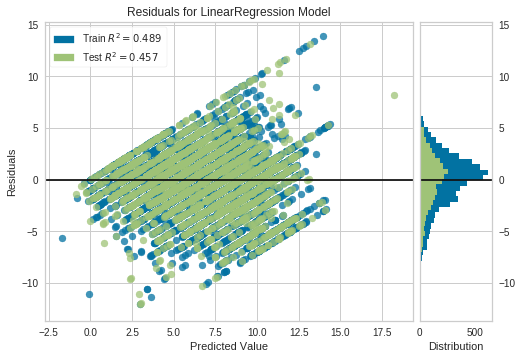

In [11]:
plot = ResidualsPlot(pipeline)
plot.fit(X_train, y_train)
plot.score(X_valid, y_valid)
plot.show();

Esta distribucion debe estar centrada en cero y deberia tender a ser simetrica.

**A continuacion genere un scatter plot entre la prediccion y el error.** 

Esto deberia verse principalmente como ruido, ya que no deberia haber correlacion entre estos valores.

-----
**NOTA**: el gráfico de residuos de arriba incluye un scatter plot entre predicción y error.

-----

Finalmente el ultimo grafico que realizaremos es el QQ Plot, que nos indicara la distribucion del error a lo largo de los cuartiles.

**Genere un qq plot con las predicciones realizadas.**
(from statsmodels.graphics.gofplots import qqplot)


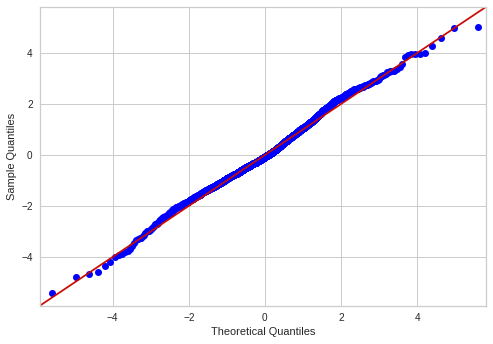

In [12]:
fig = sm.qqplot(y_valid - y_valid_pred, stats.t, fit=True, line='45')
plt.show()

En este caso los valores deben concentrarse sobre la linea diagonal.

#### Opcional:

La regularizacion es un metodo mediante el cual se penalisa el valor obsoluto de los coeficientes, de este modo se encuentran modelos mas estables y menos propensos a overfiear los datos.

Implemente una Regresion tipo Lasso (Regularizacion tipo L1) o tipo Ridge (Regularizacion tipo L2), calcula sus metricas y compare con la regresion lineal comun.

## 5. Importancia de las variables, Regresion Lineal

En base a la arquitectura del modelo y utilizando los coeficientes del modelo, determine cuales son las 10 variables de mayor peso en el modelo y explique porque.

In [13]:
col_scores = sorted(
    [
        (i, X_train.columns[i], abs(coef))
        for i, coef in enumerate(regression.coef_)
    ],
    key=(lambda col_coef_tuple: col_coef_tuple[-1]),
    reverse=True
)

display_markdown('**Top 10 most important variables**:')
display_markdown(
    '| Column index | Variable name | Score |\n' +
    '| ------------ | ------------- | ----- |\n' +
    '\n'.join(
        f'| {col_index} | {col_name} | {score:.2f} |'
        for col_index, col_name, score in col_scores[:10]
    )
)

**Top 10 most important variables**:

| Column index | Variable name | Score |
| -------------- | ------------- | ----- |
| 0 | CONJ | 3287.86 |
| 91 | SUB_is_SEITI | 324.64 |
| 88 | SUB_is_SEAUA | 278.84 |
| 17 | TR_S_CONJ | 204.18 |
| 41 | ENDNODE | 203.90 |
| 92 | SUB_is_SESAQ | 202.28 |
| 65 | CTMT_is_1_SEAUA_1 | 190.80 |
| 67 | CTMT_is_1_SEITI_1 | 187.88 |
| 93 | SUB_is_SETMG | 165.83 |
| 89 | SUB_is_SECON | 162.87 |

**TO-DO JUSTIFICAR** (https://machinelearningmastery.com/calculate-feature-importance-with-python/).

**Observación**: si utilizo sólo el robust scaler (sin el standard scaler), este ranking de variables cambia significativamente.

## 6. Preparacion de datos para algoritmos basados en arboles

Otra rama muy utilizada de modelos son aquellos basados en arboles de decision, como Bagging, Random Forrest o Boosting. En nuestro caso utilizaremos una implementacion de Boosting por gradiente denominada XGBoost que es reconocida por producir muy buenos resultados.

Dada la naturaleza de los arboles de decision en este caso es necesario normalizar los datos. Para demostrarlo, entrene dos modelos con parametros por default, utilizando el dataset normalizado y sin normalizar.

In [14]:
not_normal_xgb_regressor = xgb.XGBRegressor(random_state=42)
not_normal_xgb_regressor.fit(X_train, y_train);

In [15]:
normal_xgb_regressor = xgb.XGBRegressor(random_state=42)
normal_xgb_regressor.fit(
    robust_scaler.transform(std_scaler.transform(X_train)),
    y_train
);

In [16]:
not_normal_valid_pred = not_normal_xgb_regressor.predict(X_valid)
normal_valid_pred = normal_xgb_regressor.predict(
    robust_scaler.transform(std_scaler.transform(X_valid))
)
pd.DataFrame(data={
    'Prediction (without normalization)': not_normal_valid_pred,
    'Prediction (with normalization)': normal_valid_pred,
    'Real': y_valid,
    'Error (without normalization)': (not_normal_valid_pred - y_valid).abs(),
    'Error (with normalization)': (normal_valid_pred - y_valid).abs(),
}).sample(15)

,Prediction (without normalization),Prediction (with normalization),Real,Error (without normalization),Error (with normalization)
4329,4.411620,3.550816,4.0,0.411620,0.449184
4691,2.937543,2.996951,4.0,1.062457,1.003049
7949,5.101163,5.317029,0.0,5.101163,5.317029
5849,1.404833,1.166744,0.0,1.404833,1.166744
2641,4.226642,4.251495,1.5,2.726642,2.751495
8063,5.816832,4.340064,6.0,0.183168,1.659936
2876,12.035615,12.347604,15.0,2.964385,2.652396
6428,5.184524,5.858788,4.0,1.184524,1.858788
303,12.308623,12.446021,12.0,0.308623,0.446021
8247,10.120708,10.221394,11.0,0.879292,0.778606


### Evaluacion del modelo, XGBoost

Seleccione uno de los modelos, calcule las metricas y realize el analisis un analisis de residuos, similar al realizado anteriormente.

In [17]:
y_train_pred = not_normal_xgb_regressor.predict(X_train)
y_valid_pred = not_normal_xgb_regressor.predict(X_valid)

metric_functions = [
    ('R squared', r2_score),
    ('Mean absolute error', mean_absolute_error),
    ('Mean squared error', mean_squared_error)
]

for metric_function_name, metric_function in metric_functions:
    train_error = metric_function(y_train, y_train_pred)
    valid_error = metric_function(y_valid, y_valid_pred)
    display_markdown(f'**{metric_function_name}**:\n'
                     f'* Train error: {train_error:2f}\n'
                     f'* Validation error: {valid_error:2f}')

**R squared**:
* Train error: 0.950245
* Validation error: 0.729571

**Mean absolute error**:
* Train error: 0.636998
* Validation error: 1.473470

**Mean squared error**:
* Train error: 0.743569
* Validation error: 4.014440

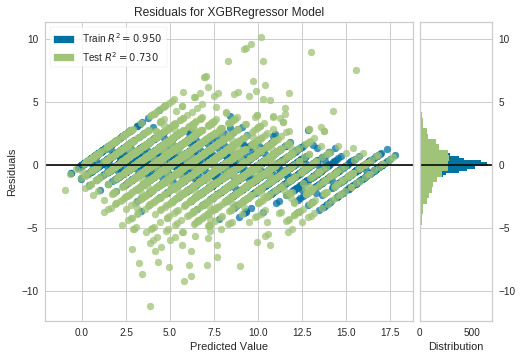

In [18]:
plot = ResidualsPlot(not_normal_xgb_regressor)
plot.fit(X_train, y_train)
plot.score(X_valid, y_valid)
plot.show();

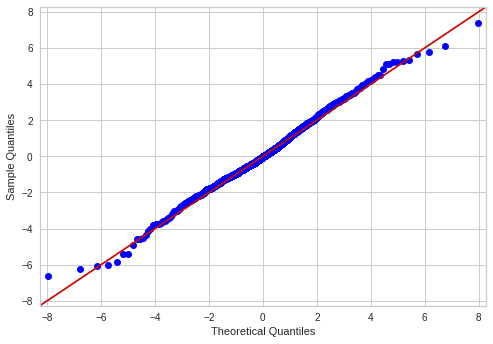

In [19]:
fig = sm.qqplot(y_valid - y_valid_pred, stats.t, fit=True, line='45')
plt.show()

## 7. Importancia de las variables

Utilize el metodo "Feature Importance" para determinar las 10 variables mas importante del modelo, verifique los diferentes criterios de calculo, seleccione uno y grafique sus coeficientes.

In [20]:
col_scores = sorted(
    [
        (i, X_train.columns[i], importance)
        for i, importance in enumerate(not_normal_xgb_regressor.feature_importances_)
    ],
    key=(lambda col_importance_tuple: col_importance_tuple[-1]),
    reverse=True
)

display_markdown('**Top 10 most important variables**:')
display_markdown(
    '| Column index | Variable name | Score |\n' +
    '| ------------ | ------------- | ----- |\n' +
    '\n'.join(
        f'| {col_index} | {col_name} | {score:.2f} |'
        for col_index, col_name, score in col_scores[:10]
    )
)

**Top 10 most important variables**:

| Column index | Variable name | Score |
| -------------- | ------------- | ----- |
| 54 | TR_S_connection_age_days | 0.33 |
| 91 | SUB_is_SEITI | 0.08 |
| 56 | FAS_CON_P_is_AB | 0.08 |
| 69 | CTMT_is_1_SETMG_1 | 0.06 |
| 47 | ARE_LOC_is_NU | 0.04 |
| 78 | CTMT_is_3_SEEST_1 | 0.04 |
| 85 | CTMT_is_5_SEEST_1 | 0.03 |
| 41 | ENDNODE | 0.03 |
| 80 | CTMT_is_3_SESAQ_1 | 0.03 |
| 81 | CTMT_is_3_SETMG_1 | 0.03 |

## 8. (Opcional) Conversion a problema de clasificacion

Podemos cambiar la naturaleza del problema de regresion a clasificacion simplemente cuantizando la salida y asignando una categoria cada intervalo.

Separe la salida en 5 intervalos segun su criterio, asignele categorias de 0 a 5, siendo 0 la peor calidad y 5 la mejor.

Entrene un classificador XGBoost, y calcule las metricas de accuracy, precision, recall, f1 score.

## 9. Conclusiones

A partir de todos los puntos anteriores exponga sus impresiones y conclusiones personales.

* Sin dudas saber cómo transformar los datos antes del entrenamiento mejora los resultados. No tenemos que tener miedo de agregar columnas, estos modelos de regresión son rápidos de entrenar.
* Al usar un modelo de regresión lineal básico de Scikit Learn hay que tener cuidado cuando se escalan los datos; usar un método u otro puede conducir a resultados muy distintos. Sin embargo, el regresor de XGBoost parece no tener este problema, sin mencionar que los resultados obtenidos fueron mucho mejores.